# Description about the code

https://www.kaggle.com/usdot/pipeline-accidents#database.csv



We need to classify the accident cause category based on the combination of pipeline and liquid type.

# Importing libs and creating useful methods/constants


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as shc

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics.cluster import contingency_matrix

sns.set(rc={'figure.figsize':(14,6)})

# Defining constants for the database columns
C_REPORT_NUM                = 'Report Number'
C_SUPPLEMENTAL_NUM          = 'Supplemental Number'
C_ACCIDENT_YEAR             = 'Accident Year'
C_ACCIDENT_DATE             = 'Accident Date/Time'
C_HOUR_OF_DAY               = 'Hour of day'
C_DAY_OF_WEEK               = 'Day of the week'
C_MONTH                     = 'Month of the year'
C_OPERATOR_ID               = 'Operator ID'
C_OPERATOR_NAME             = 'Operator Name'
C_PIPELINE_FAC_NAME         = 'Pipeline/Facility Name'
C_PIPELINE_LOCATION         = 'Pipeline Location'
C_PIPELINE_TYPE             = 'Pipeline Type'
C_LIQUID_TYPE               = 'Liquid Type'
C_LIQUID_SUBTYPE            = 'Liquid Subtype'
C_LIQUID_NAME               = 'Liquid Name'
C_ACCIDENT_CITY             = 'Accident City'
C_ACCIDENT_COUNTY           = 'Accident County'
C_ACCIDENT_STATE            = 'Accident State'
C_ACCIDENT_LAT              = 'Accident Latitude'
C_ACCIDENT_LONG             = 'Accident Longitude'
C_CAUSE_CAT                 = 'Cause Category' # !!!!!!!!!!!! TARGET VARIABLE !!!!!!!!
C_CAUSE_SUBCAT              = 'Cause Subcategory'
C_UNIN_RELEASE              = 'Unintentional Release (Barrels)'
C_INTENT_RELEASE            = 'Intentional Release (Barrels)'
C_LIQUID_RECOV              = 'Liquid Recovery (Barrels)'
C_NET_LOSS                  = 'Net Loss (Barrels)'
C_LIQUID_IGN                = 'Liquid Ignition'
C_LIQUID_EXPL               = 'Liquid Explosion'
C_PIPELINE_SHUT             = 'Pipeline Shutdown'
C_SHUTDOWN_DATE             = 'Shutdown Date/Time'
C_RESTART_DATE              = 'Restart Date/Time'
C_PUBLIC_EVAC               = 'Public Evacuations'
C_OPERATOR_EMPLOYEE_INJU    = 'Operator Employee Injuries'
C_OPERATOR_CONTR_INJU       = 'Operator Contractor Injuries'
C_EMERGENCY_RESP_INJU       = 'Emergency Responder Injuries'
C_OTHER_INJU                = 'Other Injuries'
C_PUBLIC_INJU               = 'Public Injuries'
C_ALL_INJU                  = 'All Injuries'
C_OPERATOR_EMPL_FAT         = 'Operator Employee Fatalities'
C_OPERATOR_CONTR_FAT        = 'Operator Contractor Fatalities'
C_EMERGENCY_RESP_FAT        = 'Emergency Responder Fatalities'
C_OTHER_FAT                 = 'Other Fatalities'
C_PUBLIC_FAT                = 'Public Fatalities'
C_ALL_FAT                   = 'All Fatalities'
C_PROPERTY_DMG              = 'Property Damage Costs'
C_LOST_COMMO                = 'Lost Commodity Costs'
C_PUBLIC_PRIV               = 'Public/Private Property Damage Costs'
C_EMERGENCY_RESP            = 'Emergency Response Costs'
C_ENVIRONMENTAL_REM         = 'Environmental Remediation Costs'
C_OTHER_COSTS               = 'Other Costs'
C_ALL_COSTS                 = 'All Costs'

def feature_scaling(data):
    sc = StandardScaler()
    return sc.fit_transform(data)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.__version__

'1.0.3'

# Reading database and preparing to pre-process the data

In [0]:
oil_pipeline_accidents = pd.read_csv("https://raw.githubusercontent.com/" +
                                     "JGeraldoLima/ai_playground/master/" +
                                     "oil_pipelines_accidents/" +
                                     "oil_pipeline_accidents.csv")

In [4]:
oil_pipeline_accidents.head()

,Report Number,Supplemental Number,Accident Year,Accident Date/Time,Operator ID,Operator Name,Pipeline/Facility Name,Pipeline Location,Pipeline Type,Liquid Type,Liquid Subtype,Liquid Name,Accident City,Accident County,Accident State,Accident Latitude,Accident Longitude,Cause Category,Cause Subcategory,Unintentional Release (Barrels),Intentional Release (Barrels),Liquid Recovery (Barrels),Net Loss (Barrels),Liquid Ignition,Liquid Explosion,Pipeline Shutdown,Shutdown Date/Time,Restart Date/Time,Public Evacuations,Operator Employee Injuries,Operator Contractor Injuries,Emergency Responder Injuries,Other Injuries,Public Injuries,All Injuries,Operator Employee Fatalities,Operator Contractor Fatalities,Emergency Responder Fatalities,Other Fatalities,Public Fatalities,All Fatalities,Property Damage Costs,Lost Commodity Costs,Public/Private Property Damage Costs,Emergency Response Costs,Environmental Remediation Costs,Other Costs,All Costs
0,20100016,17305,2010,1/1/2010 7:15 AM,32109,ONEOK NGL PIPELINE LP,KINDER MORGAN JCT,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",LPG (LIQUEFIED PETROLEUM GAS) / NGL (NATURAL G...,NaN,MCPHERSON,MCPHERSON,KS,38.67070,-97.78123,INCORRECT OPERATION,PIPELINE/EQUIPMENT OVERPRESSURED,21.00,0.1,0.00,21.0,NO,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,1517.0,0.0,0.0,0.0,0.0,1627
1,20100254,17331,2010,1/4/2010 8:30 AM,15786,PORTLAND PIPELINE CORP,24-INCH MAIN LINE,ONSHORE,ABOVEGROUND,CRUDE OIL,NaN,NaN,RAYMOND,CUMBERLAND,ME,43.94028,-70.49336,MATERIAL/WELD/EQUIP FAILURE,PUMP OR PUMP-RELATED EQUIPMENT,0.12,0.0,0.12,0.0,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,8.0,0.0,0.0,0.0,0.0,4008
2,20100038,17747,2010,1/5/2010 10:30 AM,20160,"PETROLOGISTICS OLEFINS, LLC",NaN,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",OTHER HVL,ETHANE,SULPHER,CALCASIEU,LA,30.18240,-93.35240,MATERIAL/WELD/EQUIP FAILURE,DEFECTIVE OR LOOSE TUBING/FITTING,2.00,0.0,0.00,2.0,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,200.0,0.0,0.0,0.0,0.0,200
3,20100260,18574,2010,1/6/2010 7:30 PM,11169,"ENBRIDGE ENERGY, LIMITED PARTNERSHIP",SUPERIOR TERMINAL,ONSHORE,UNDERGROUND,CRUDE OIL,NaN,NaN,SUPERIOR,DOUGLAS,WI,46.68930,-92.06120,NATURAL FORCE DAMAGE,TEMPERATURE,0.48,0.0,0.48,0.0,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,40.0,0.0,11300.0,0.0,0.0,11540
4,20100030,16276,2010,1/7/2010 1:00 PM,300,"PLAINS PIPELINE, L.P.",RED RIVER EAST,ONSHORE,UNDERGROUND,CRUDE OIL,NaN,NaN,SHERMAN,GRAYSON,TX,33.58266,-96.64881,EXCAVATION DAMAGE,THIRD PARTY EXCAVATION DAMAGE,700.00,NaN,698.00,2.0,NO,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000.0,150.0,0.0,7500.0,2000.0,0.0,29650


## Getting rid of unuseful data

In [5]:
oil_pipeline_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 48 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Report Number                         2795 non-null   int64  
 1   Supplemental Number                   2795 non-null   int64  
 2   Accident Year                         2795 non-null   int64  
 3   Accident Date/Time                    2795 non-null   object 
 4   Operator ID                           2795 non-null   int64  
 5   Operator Name                         2795 non-null   object 
 6   Pipeline/Facility Name                2674 non-null   object 
 7   Pipeline Location                     2795 non-null   object 
 8   Pipeline Type                         2777 non-null   object 
 9   Liquid Type                           2795 non-null   object 
 10  Liquid Subtype                        1349 non-null   object 
 11  Liquid Name      

### Dropping columns which have mostly NaN values (based on resumed columns values distribution from Kaggle)

In [0]:
ignored_columns = [C_LIQUID_SUBTYPE, 
                   C_LIQUID_NAME, 
                   C_OPERATOR_EMPLOYEE_INJU, 
                   C_OPERATOR_CONTR_INJU,      
                   C_EMERGENCY_RESP_INJU,       
                   C_OTHER_INJU,                
                   C_PUBLIC_INJU,              
                   C_ALL_INJU,                  
                   C_OPERATOR_EMPL_FAT,         
                   C_OPERATOR_CONTR_FAT,        
                   C_EMERGENCY_RESP_FAT,        
                   C_OTHER_FAT,                 
                   C_PUBLIC_FAT,               
                   C_ALL_FAT]
                   
not_ignored_filter = ~oil_pipeline_accidents.columns.isin(ignored_columns)
columns_not_ignored = oil_pipeline_accidents.columns[not_ignored_filter]
oil_pipeline_accidents = oil_pipeline_accidents[columns_not_ignored]

In [7]:
oil_pipeline_accidents.head()

,Report Number,Supplemental Number,Accident Year,Accident Date/Time,Operator ID,Operator Name,Pipeline/Facility Name,Pipeline Location,Pipeline Type,Liquid Type,Accident City,Accident County,Accident State,Accident Latitude,Accident Longitude,Cause Category,Cause Subcategory,Unintentional Release (Barrels),Intentional Release (Barrels),Liquid Recovery (Barrels),Net Loss (Barrels),Liquid Ignition,Liquid Explosion,Pipeline Shutdown,Shutdown Date/Time,Restart Date/Time,Public Evacuations,Property Damage Costs,Lost Commodity Costs,Public/Private Property Damage Costs,Emergency Response Costs,Environmental Remediation Costs,Other Costs,All Costs
0,20100016,17305,2010,1/1/2010 7:15 AM,32109,ONEOK NGL PIPELINE LP,KINDER MORGAN JCT,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",MCPHERSON,MCPHERSON,KS,38.67070,-97.78123,INCORRECT OPERATION,PIPELINE/EQUIPMENT OVERPRESSURED,21.00,0.1,0.00,21.0,NO,NO,NO,NaN,NaN,NaN,110.0,1517.0,0.0,0.0,0.0,0.0,1627
1,20100254,17331,2010,1/4/2010 8:30 AM,15786,PORTLAND PIPELINE CORP,24-INCH MAIN LINE,ONSHORE,ABOVEGROUND,CRUDE OIL,RAYMOND,CUMBERLAND,ME,43.94028,-70.49336,MATERIAL/WELD/EQUIP FAILURE,PUMP OR PUMP-RELATED EQUIPMENT,0.12,0.0,0.12,0.0,NO,NO,NaN,NaN,NaN,NaN,4000.0,8.0,0.0,0.0,0.0,0.0,4008
2,20100038,17747,2010,1/5/2010 10:30 AM,20160,"PETROLOGISTICS OLEFINS, LLC",NaN,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",SULPHER,CALCASIEU,LA,30.18240,-93.35240,MATERIAL/WELD/EQUIP FAILURE,DEFECTIVE OR LOOSE TUBING/FITTING,2.00,0.0,0.00,2.0,NO,NO,NaN,NaN,NaN,NaN,0.0,200.0,0.0,0.0,0.0,0.0,200
3,20100260,18574,2010,1/6/2010 7:30 PM,11169,"ENBRIDGE ENERGY, LIMITED PARTNERSHIP",SUPERIOR TERMINAL,ONSHORE,UNDERGROUND,CRUDE OIL,SUPERIOR,DOUGLAS,WI,46.68930,-92.06120,NATURAL FORCE DAMAGE,TEMPERATURE,0.48,0.0,0.48,0.0,NO,NO,NaN,NaN,NaN,NaN,200.0,40.0,0.0,11300.0,0.0,0.0,11540
4,20100030,16276,2010,1/7/2010 1:00 PM,300,"PLAINS PIPELINE, L.P.",RED RIVER EAST,ONSHORE,UNDERGROUND,CRUDE OIL,SHERMAN,GRAYSON,TX,33.58266,-96.64881,EXCAVATION DAMAGE,THIRD PARTY EXCAVATION DAMAGE,700.00,NaN,698.00,2.0,NO,NO,NO,NaN,NaN,NaN,20000.0,150.0,0.0,7500.0,2000.0,0.0,29650


### Dropping columns that do not have research value

In [0]:
non_valueable_columns = [C_OPERATOR_ID,
                         C_SUPPLEMENTAL_NUM,
                         C_PIPELINE_FAC_NAME,
                         C_ACCIDENT_LAT,
                         C_ACCIDENT_LONG,
                         C_UNIN_RELEASE,
                         C_INTENT_RELEASE,
                         C_LIQUID_RECOV,
                         C_NET_LOSS,
                         C_PIPELINE_SHUT,
                         C_SHUTDOWN_DATE,
                         C_RESTART_DATE,
                         C_PUBLIC_EVAC]

not_ignored_filter = ~oil_pipeline_accidents.columns.isin(non_valueable_columns)
columns_not_ignored = oil_pipeline_accidents.columns[not_ignored_filter]
oil_pipeline_accidents = oil_pipeline_accidents[columns_not_ignored]

In [9]:
oil_pipeline_accidents.head()

,Report Number,Accident Year,Accident Date/Time,Operator Name,Pipeline Location,Pipeline Type,Liquid Type,Accident City,Accident County,Accident State,Cause Category,Cause Subcategory,Liquid Ignition,Liquid Explosion,Property Damage Costs,Lost Commodity Costs,Public/Private Property Damage Costs,Emergency Response Costs,Environmental Remediation Costs,Other Costs,All Costs
0,20100016,2010,1/1/2010 7:15 AM,ONEOK NGL PIPELINE LP,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",MCPHERSON,MCPHERSON,KS,INCORRECT OPERATION,PIPELINE/EQUIPMENT OVERPRESSURED,NO,NO,110.0,1517.0,0.0,0.0,0.0,0.0,1627
1,20100254,2010,1/4/2010 8:30 AM,PORTLAND PIPELINE CORP,ONSHORE,ABOVEGROUND,CRUDE OIL,RAYMOND,CUMBERLAND,ME,MATERIAL/WELD/EQUIP FAILURE,PUMP OR PUMP-RELATED EQUIPMENT,NO,NO,4000.0,8.0,0.0,0.0,0.0,0.0,4008
2,20100038,2010,1/5/2010 10:30 AM,"PETROLOGISTICS OLEFINS, LLC",ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",SULPHER,CALCASIEU,LA,MATERIAL/WELD/EQUIP FAILURE,DEFECTIVE OR LOOSE TUBING/FITTING,NO,NO,0.0,200.0,0.0,0.0,0.0,0.0,200
3,20100260,2010,1/6/2010 7:30 PM,"ENBRIDGE ENERGY, LIMITED PARTNERSHIP",ONSHORE,UNDERGROUND,CRUDE OIL,SUPERIOR,DOUGLAS,WI,NATURAL FORCE DAMAGE,TEMPERATURE,NO,NO,200.0,40.0,0.0,11300.0,0.0,0.0,11540
4,20100030,2010,1/7/2010 1:00 PM,"PLAINS PIPELINE, L.P.",ONSHORE,UNDERGROUND,CRUDE OIL,SHERMAN,GRAYSON,TX,EXCAVATION DAMAGE,THIRD PARTY EXCAVATION DAMAGE,NO,NO,20000.0,150.0,0.0,7500.0,2000.0,0.0,29650


### Removing 'nan' values from categorical columns

In [0]:
for column in [C_PIPELINE_TYPE, 
               C_LIQUID_TYPE, 
               C_CAUSE_CAT]:
  oil_pipeline_accidents = oil_pipeline_accidents[oil_pipeline_accidents[column]
                                                  .astype(str) != 'nan']

### Removing Nan values from other columns

In [11]:
oil_pipeline_accidents[oil_pipeline_accidents.isnull().any(axis=1)]

,Report Number,Accident Year,Accident Date/Time,Operator Name,Pipeline Location,Pipeline Type,Liquid Type,Accident City,Accident County,Accident State,Cause Category,Cause Subcategory,Liquid Ignition,Liquid Explosion,Property Damage Costs,Lost Commodity Costs,Public/Private Property Damage Costs,Emergency Response Costs,Environmental Remediation Costs,Other Costs,All Costs
8,20100261,2010,1/10/2010 7:46 PM,"KINDER MORGAN LIQUID TERMINALS, LLC",ONSHORE,ABOVEGROUND,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",NaN,NaN,TX,MATERIAL/WELD/EQUIP FAILURE,OTHER EQUIPMENT FAILURE,NO,NO,0.0,336.0,0.0,0.0,40000.0,0.0,40336
10,20100150,2010,1/11/2010 2:30 PM,TARGA RESOURCES OPERATING LP,ONSHORE,UNDERGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",LAKE CHARLES,CALCASIEU,LA,NATURAL FORCE DAMAGE,TEMPERATURE,NO,NO,29360.0,136233.0,NaN,NaN,NaN,NaN,165593
49,20100010,2010,2/25/2010 10:00 AM,COLONIAL PIPELINE CO,ONSHORE,UNDERGROUND,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",NaN,NaN,NC,MATERIAL/WELD/EQUIP FAILURE,NON-THREADED CONNECTION FAILURE,NO,NO,15200.0,50.0,0.0,0.0,0.0,700.0,15950
64,20100039,2010,3/15/2010 3:55 PM,SUNOCO PIPELINE L.P.,ONSHORE,UNDERGROUND,CRUDE OIL,WHITE OAK,GREGG,TX,MATERIAL/WELD/EQUIP FAILURE,MALFUNCTION OF CONTROL/RELIEF EQUIPMENT,NO,NO,NaN,46.0,NaN,10999.0,452.0,NaN,11497
76,20100027,2010,3/26/2010 1:50 PM,CONOCOPHILLIPS,ONSHORE,ABOVEGROUND,CRUDE OIL,BORGER,NaN,TX,INCORRECT OPERATION,OTHER INCORRECT OPERATION,NO,NO,0.0,58.0,0.0,0.0,30000.0,0.0,30058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780,20170010,2016,12/19/2016 6:45 AM,PHILLIPS 66 PIPELINE LLC,ONSHORE,ABOVEGROUND,CRUDE OIL,NaN,ECTOR,TX,MATERIAL/WELD/EQUIP FAILURE,THREADED CONNECTION/COUPLING FAILURE,NO,NO,1000.0,10.0,0.0,0.0,1000.0,0.0,2010
2781,20170019,2016,12/19/2016 1:50 PM,"MEDALLION OPERATING COMPANY, LLC",ONSHORE,ABOVEGROUND,CRUDE OIL,NaN,REAGAN,TX,NATURAL FORCE DAMAGE,TEMPERATURE,NO,NO,0.0,1500.0,0.0,2500.0,12000.0,0.0,16000
2788,20170023,2016,12/24/2016 9:35 AM,PHILLIPS 66 PIPELINE LLC,ONSHORE,ABOVEGROUND,CRUDE OIL,NaN,ARCHER,TX,MATERIAL/WELD/EQUIP FAILURE,NON-THREADED CONNECTION FAILURE,NO,NO,4100.0,10600.0,50000.0,105000.0,87810.0,1000.0,258510
2789,20170026,2016,12/26/2016 7:20 AM,"HOLLY ENERGY PARTNERS - OPERATING, L.P.",ONSHORE,ABOVEGROUND,CRUDE OIL,NaN,GAINES,TX,CORROSION,INTERNAL,NO,NO,1000.0,120.0,0.0,2000.0,10000.0,0.0,13120


### Filling numeric Nan values with 0

In [0]:
oil_pipeline_accidents.fillna(0, inplace=True)

## Creating new useful columns

In [0]:
oil_pipeline_accidents[C_ACCIDENT_DATE] = pd.to_datetime(oil_pipeline_accidents[C_ACCIDENT_DATE])

# 0-6 == monday-sunday
oil_pipeline_accidents[C_DAY_OF_WEEK] = oil_pipeline_accidents[C_ACCIDENT_DATE].dt.dayofweek 
oil_pipeline_accidents[C_HOUR_OF_DAY] = oil_pipeline_accidents[C_ACCIDENT_DATE].dt.hour
oil_pipeline_accidents[C_MONTH] = oil_pipeline_accidents[C_ACCIDENT_DATE].dt.month

In [14]:
oil_pipeline_accidents.head()

,Report Number,Accident Year,Accident Date/Time,Operator Name,Pipeline Location,Pipeline Type,Liquid Type,Accident City,Accident County,Accident State,Cause Category,Cause Subcategory,Liquid Ignition,Liquid Explosion,Property Damage Costs,Lost Commodity Costs,Public/Private Property Damage Costs,Emergency Response Costs,Environmental Remediation Costs,Other Costs,All Costs,Day of the week,Hour of day,Month of the year
0,20100016,2010,2010-01-01 07:15:00,ONEOK NGL PIPELINE LP,ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",MCPHERSON,MCPHERSON,KS,INCORRECT OPERATION,PIPELINE/EQUIPMENT OVERPRESSURED,NO,NO,110.0,1517.0,0.0,0.0,0.0,0.0,1627,4,7,1
1,20100254,2010,2010-01-04 08:30:00,PORTLAND PIPELINE CORP,ONSHORE,ABOVEGROUND,CRUDE OIL,RAYMOND,CUMBERLAND,ME,MATERIAL/WELD/EQUIP FAILURE,PUMP OR PUMP-RELATED EQUIPMENT,NO,NO,4000.0,8.0,0.0,0.0,0.0,0.0,4008,0,8,1
2,20100038,2010,2010-01-05 10:30:00,"PETROLOGISTICS OLEFINS, LLC",ONSHORE,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",SULPHER,CALCASIEU,LA,MATERIAL/WELD/EQUIP FAILURE,DEFECTIVE OR LOOSE TUBING/FITTING,NO,NO,0.0,200.0,0.0,0.0,0.0,0.0,200,1,10,1
3,20100260,2010,2010-01-06 19:30:00,"ENBRIDGE ENERGY, LIMITED PARTNERSHIP",ONSHORE,UNDERGROUND,CRUDE OIL,SUPERIOR,DOUGLAS,WI,NATURAL FORCE DAMAGE,TEMPERATURE,NO,NO,200.0,40.0,0.0,11300.0,0.0,0.0,11540,2,19,1
4,20100030,2010,2010-01-07 13:00:00,"PLAINS PIPELINE, L.P.",ONSHORE,UNDERGROUND,CRUDE OIL,SHERMAN,GRAYSON,TX,EXCAVATION DAMAGE,THIRD PARTY EXCAVATION DAMAGE,NO,NO,20000.0,150.0,0.0,7500.0,2000.0,0.0,29650,3,13,1


# Analysing data

## Checking data distributions

### How many accidents occured by hour of day?

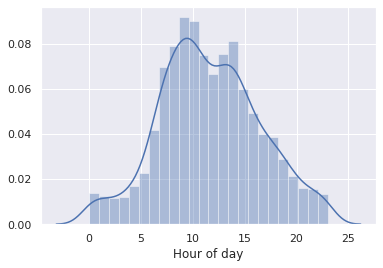

In [15]:
sns.distplot(oil_pipeline_accidents[C_HOUR_OF_DAY], bins=24)

As we can see, most of the accidents occured **between 7h and 15h**.

---



**FIND SOME ARTICLE ABOUT OIL ACTIVITIES SCHEDULE TO EXPLAIN THESE EPOCHS**

### How many accidents occured by day of week?

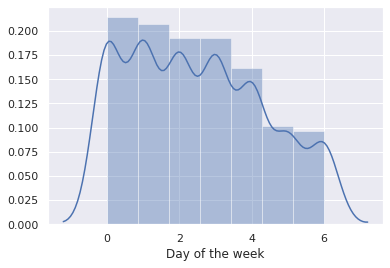

In [16]:
sns.distplot(oil_pipeline_accidents[C_DAY_OF_WEEK], bins=7)

So, most of the accidents occured **between Monday and Friday**.


---
**FIND SOME ARTICLE ABOUT OIL ACTIVITIES SCHEDULE TO EXPLAIN THESE EPOCHS**

### How many accidents occured by month (***TODO*** see if the warmer season may contribute)?

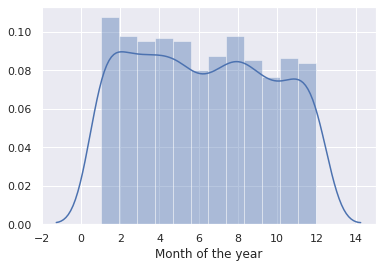

In [17]:
sns.distplot(oil_pipeline_accidents[C_MONTH], bins=12)

Despite the distribution appears to be regular between the months, most of the accidents occurred in the **beginning of the year**, with *significant falls* in **June** and **October**.


---



**FIND SOME ARTICLE ABOUT OIL ACTIVITIES SCHEDULE TO EXPLAIN THESE EPOCHS**

### How many accidents occured by year (***TODO*** see if the number decreased over the years)?

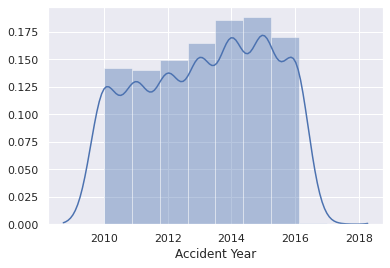

In [18]:
sns.distplot(oil_pipeline_accidents[C_ACCIDENT_YEAR], bins=len(np.unique(oil_pipeline_accidents[C_ACCIDENT_YEAR])))

As we can see, the accidents rate appears to decrease from **year 2016**.

### How many accidents occured by pipeline location?

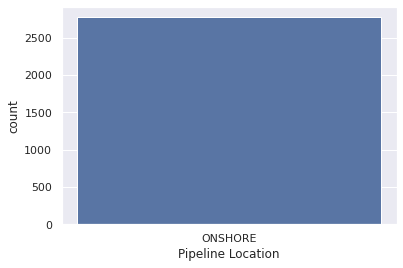

In [19]:
sns.countplot(x=C_PIPELINE_LOCATION, data=oil_pipeline_accidents)

So, almost all of the considered accidents occurred in **Onshore** exploration environment.

### How many accidents occured by pipeline type?

[Text(0, 0, 'ABOVEGROUND'),
 Text(0, 0, 'UNDERGROUND'),
 Text(0, 0, 'TANK'),
 Text(0, 0, 'TRANSITION AREA')]

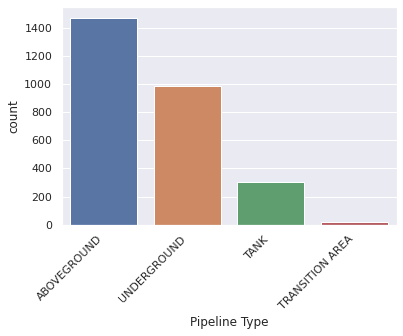

In [20]:
ax = sns.countplot(x=C_PIPELINE_TYPE, data=oil_pipeline_accidents)
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right')

So, most of the accidents were caused by **underground** and **aboveground** pipeline types.

### How many accidents occured by liquid type?

[Text(0, 0, 'HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS'),
 Text(0, 0, 'CRUDE OIL'),
 Text(0, 0, 'REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID'),
 Text(0, 0, 'CO2 (CARBON DIOXIDE)'),
 Text(0, 0, 'BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS)')]

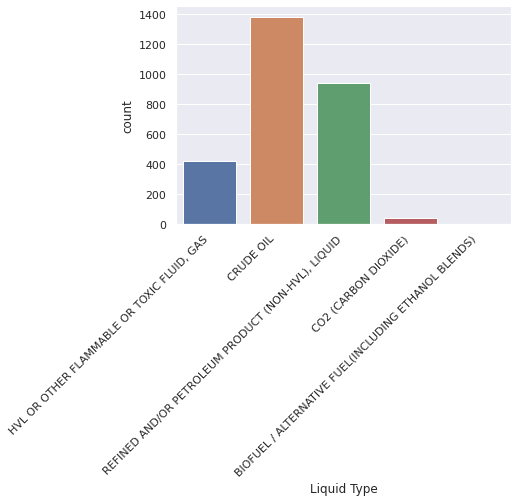

In [21]:
ax = sns.countplot(x=C_LIQUID_TYPE, 
                   data=oil_pipeline_accidents)
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right')

So, most of the accidents were caused by **crude oil** and **refined and or petroleum product** liquid types and almost none by **biofuel / alternative fuel**.

### Which categories have more classified accidents by?

[Text(0, 0, 'INCORRECT OPERATION'),
 Text(0, 0, 'MATERIAL/WELD/EQUIP FAILURE'),
 Text(0, 0, 'NATURAL FORCE DAMAGE'),
 Text(0, 0, 'EXCAVATION DAMAGE'),
 Text(0, 0, 'ALL OTHER CAUSES'),
 Text(0, 0, 'CORROSION'),
 Text(0, 0, 'OTHER OUTSIDE FORCE DAMAGE')]

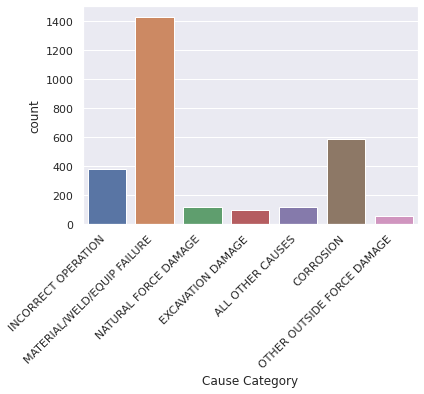

In [22]:
ax = sns.countplot(x=C_CAUSE_CAT, data=oil_pipeline_accidents)
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right')

As shown above, most of the accidents were caused by **material / bad weld / equip failure** and **corrosion**, with a significant amount for **incorrect operation**.

## Checking the correlations with target variable (**cause category**)

First, we will generate the dummie columns in order to get the numeric values for string columns.

In [0]:
le_pipe_type = LabelEncoder() 
oil_pipeline_accidents[C_PIPELINE_TYPE] = le_pipe_type.fit_transform(
                                              oil_pipeline_accidents[C_PIPELINE_TYPE]
                                                         .astype(str))

le_pipe_type_mapping = dict(zip(le_pipe_type.classes_, 
                                le_pipe_type.transform(le_pipe_type.classes_)))
le_pipe_type_mapping = {k: v for k, v in sorted(le_pipe_type_mapping.items(), 
                                                key=lambda item: item[1])}

In [24]:
le_pipe_type_mapping

{'ABOVEGROUND': 0, 'TANK': 1, 'TRANSITION AREA': 2, 'UNDERGROUND': 3}

In [0]:
le_cause_cat = LabelEncoder() 
oil_pipeline_accidents[C_CAUSE_CAT] = le_cause_cat.fit_transform(oil_pipeline_accidents[C_CAUSE_CAT].astype(str))

le_cause_cat_mapping = dict(zip(le_cause_cat.classes_, le_cause_cat.transform(le_cause_cat.classes_)))
le_cause_cat_mapping = {k: v for k, v in sorted(le_cause_cat_mapping.items(), key=lambda item: item[1])}

In [57]:
le_cause_cat_mapping

{'ALL OTHER CAUSES': 0,
 'CORROSION': 1,
 'EXCAVATION DAMAGE': 2,
 'INCORRECT OPERATION': 3,
 'MATERIAL/WELD/EQUIP FAILURE': 4,
 'NATURAL FORCE DAMAGE': 5,
 'OTHER OUTSIDE FORCE DAMAGE': 6}

In [0]:
le_liq_type = LabelEncoder() 
oil_pipeline_accidents[C_LIQUID_TYPE] = le_liq_type.fit_transform(oil_pipeline_accidents[C_LIQUID_TYPE].astype(str))

le_liq_type_mapping = dict(zip(le_liq_type.classes_, le_liq_type.transform(le_liq_type.classes_)))
le_liq_type_mapping = {k: v for k, v in sorted(le_liq_type_mapping.items(), key=lambda item: item[1])}

In [27]:
oil_pipeline_accidents.head()

,Report Number,Accident Year,Accident Date/Time,Operator Name,Pipeline Location,Pipeline Type,Liquid Type,Accident City,Accident County,Accident State,Cause Category,Cause Subcategory,Liquid Ignition,Liquid Explosion,Property Damage Costs,Lost Commodity Costs,Public/Private Property Damage Costs,Emergency Response Costs,Environmental Remediation Costs,Other Costs,All Costs,Day of the week,Hour of day,Month of the year
0,20100016,2010,2010-01-01 07:15:00,ONEOK NGL PIPELINE LP,ONSHORE,0,3,MCPHERSON,MCPHERSON,KS,3,PIPELINE/EQUIPMENT OVERPRESSURED,NO,NO,110.0,1517.0,0.0,0.0,0.0,0.0,1627,4,7,1
1,20100254,2010,2010-01-04 08:30:00,PORTLAND PIPELINE CORP,ONSHORE,0,2,RAYMOND,CUMBERLAND,ME,4,PUMP OR PUMP-RELATED EQUIPMENT,NO,NO,4000.0,8.0,0.0,0.0,0.0,0.0,4008,0,8,1
2,20100038,2010,2010-01-05 10:30:00,"PETROLOGISTICS OLEFINS, LLC",ONSHORE,0,3,SULPHER,CALCASIEU,LA,4,DEFECTIVE OR LOOSE TUBING/FITTING,NO,NO,0.0,200.0,0.0,0.0,0.0,0.0,200,1,10,1
3,20100260,2010,2010-01-06 19:30:00,"ENBRIDGE ENERGY, LIMITED PARTNERSHIP",ONSHORE,3,2,SUPERIOR,DOUGLAS,WI,5,TEMPERATURE,NO,NO,200.0,40.0,0.0,11300.0,0.0,0.0,11540,2,19,1
4,20100030,2010,2010-01-07 13:00:00,"PLAINS PIPELINE, L.P.",ONSHORE,3,2,SHERMAN,GRAYSON,TX,2,THIRD PARTY EXCAVATION DAMAGE,NO,NO,20000.0,150.0,0.0,7500.0,2000.0,0.0,29650,3,13,1


### Pipeline Type

[Text(0, 0.5, 'ALL OTHER CAUSES'),
 Text(0, 1.5, 'CORROSION'),
 Text(0, 2.5, 'EXCAVATION DAMAGE'),
 Text(0, 3.5, 'INCORRECT OPERATION'),
 Text(0, 4.5, 'MATERIAL/WELD/EQUIP FAILURE'),
 Text(0, 5.5, 'NATURAL FORCE DAMAGE'),
 Text(0, 6.5, 'OTHER OUTSIDE FORCE DAMAGE')]

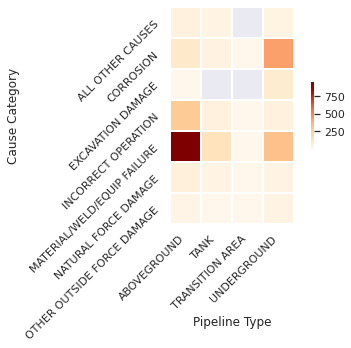

In [28]:
by_pipe_type = (oil_pipeline_accidents
                .groupby([C_CAUSE_CAT, C_PIPELINE_TYPE])
                .size()
                .unstack()
           )
by_pipe_type.fillna(0)

g = sns.heatmap(
    by_pipe_type, 
    square=True,
    cbar_kws={'fraction' : 0.01},
    cmap='OrRd',
    linewidth=1
)
g.set_xticklabels([*le_pipe_type_mapping], 
                  rotation=45, 
                  horizontalalignment='right')
g.set_yticklabels([*le_cause_cat_mapping], 
                  rotation=45, 
                  horizontalalignment='right')

From the previous chart, we have:

*   **Aboveground** pipelines are the main cause of **material/weld/equip failure** accidents;
*   **Underground** pipelines are the main cause of **corrosion** accidents;
*   **Underground** pipelines have an expressive blame rate in **material/weld/equip failure** accidents;
*   **Aboveground** pipelines are closely related to **incorrect operation** accidents;
*   **Tank** pipelines have a small portion of blame in **material/weld/equip failure** accidents;
*   **Aboveground** have a small portion of blame in **corrosion** accidents;

### Liquid Type

[Text(0, 0.5, 'ALL OTHER CAUSES'),
 Text(0, 1.5, 'CORROSION'),
 Text(0, 2.5, 'EXCAVATION DAMAGE'),
 Text(0, 3.5, 'INCORRECT OPERATION'),
 Text(0, 4.5, 'MATERIAL/WELD/EQUIP FAILURE'),
 Text(0, 5.5, 'NATURAL FORCE DAMAGE'),
 Text(0, 6.5, 'OTHER OUTSIDE FORCE DAMAGE')]

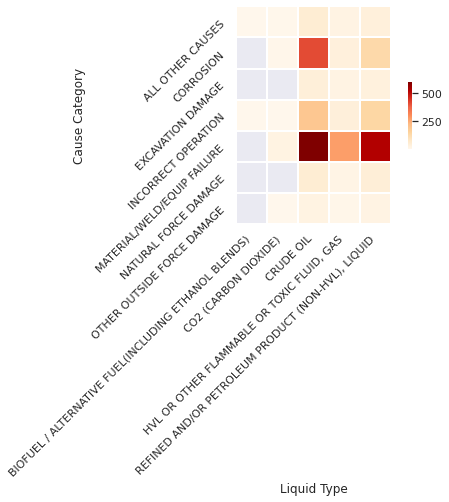

In [29]:
by_liq_type = (oil_pipeline_accidents
                .groupby([C_CAUSE_CAT, C_LIQUID_TYPE])
                .size()
                .unstack()
           )
by_liq_type.fillna(0)

g = sns.heatmap(
    by_liq_type, 
    square=True,
    cbar_kws={'fraction' : 0.01},
    cmap='OrRd',
    linewidth=1
)
g.set_xticklabels([*le_liq_type_mapping], rotation=45, horizontalalignment='right')
g.set_yticklabels([*le_cause_cat_mapping], rotation=45, horizontalalignment='right')

From the previous chart, we have:

*   **Crude oil** fluid are the main cause of **material/weld/equip failure** accidents;
*   **Refined / petroleum product** fluids are the main cause of **material/weld/equip failure** accidents;
*   **Crude oil** fluid have an expressive blame rate in **corrosion** accidents;
*   **HVL / other flammable / toxic** fluids are closely related to **material/weld/equip failure** accidents;
*   **Crude oil** fluid have a small portion of blame in **incorrect operation** accidents;
*   **Refined / petroleum product** fluids have a small portion of blame in **incorrect operation** accidents;
*   **Refined / petroleum product** fluids have a small portion of blame in **corrosion** accidents;

### Liquid Type x Pipeline type

Let's check which combinations causes more accidents

[Text(0, 0.5, 'BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS)'),
 Text(0, 1.5, 'CO2 (CARBON DIOXIDE)'),
 Text(0, 2.5, 'CRUDE OIL'),
 Text(0, 3.5, 'HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS'),
 Text(0, 4.5, 'REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID')]

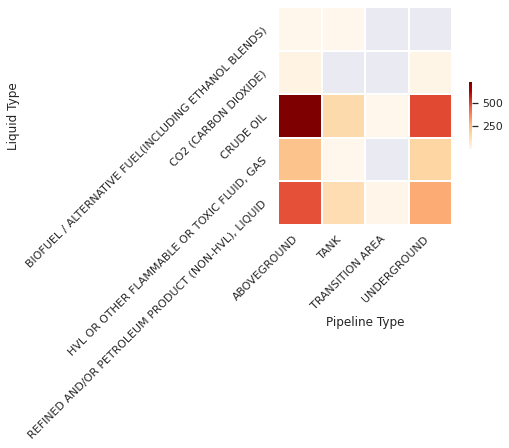

In [30]:
by_liq_pipe_type = (oil_pipeline_accidents
                .groupby([C_LIQUID_TYPE, C_PIPELINE_TYPE])
                .size()
                .unstack()
           )
by_liq_pipe_type.fillna(0)

g = sns.heatmap(
    by_liq_pipe_type, 
    square=True,
    cbar_kws={'fraction' : 0.01},
    cmap='OrRd',
    linewidth=1
)
g.set_xticklabels([*le_pipe_type_mapping], rotation=45, horizontalalignment='right')
g.set_yticklabels([*le_liq_type_mapping], rotation=45, horizontalalignment='right')

From the previous chart, we have:

*   Accidents caused by **aboveground** pipeline type were strongly related to **crude oil** and **refined / petroleum product** fluids and closely related to **HVL / other flammable / toxic**;
*   Accidents caused by **underground** pipeline type were strongly related to **crude oil** fluid and closely related to **HVL / other flammable / toxic** and **refined / petroleum product** fluids;
*   Accidents caused by **tank** pipeline type were closely related to **crude oil** and **refined / petroleum product** accidents;

# Clustering data

### Creating a results dataframe

In [0]:
df_clustering_results = pd.DataFrame(columns=['alg', 'n_clusters', 'silhouette', 'V-measure'])

### Checking the value counts for each dummie candidate column

In [0]:
 dummie_columns = [C_OPERATOR_NAME, C_PIPELINE_LOCATION, C_ACCIDENT_CITY, C_ACCIDENT_COUNTY, C_ACCIDENT_STATE, C_CAUSE_SUBCAT, C_LIQUID_IGN, C_LIQUID_EXPL]

In [33]:
for c in dummie_columns:
  print('********* {} value_count ***********'.format(c))
  print(oil_pipeline_accidents[c].value_counts())
  print('\n')

********* Operator Name value_count ***********
ENTERPRISE CRUDE PIPELINE LLC        195
SUNOCO PIPELINE L.P.                 180
PLAINS PIPELINE, L.P.                156
ENTERPRISE PRODUCTS OPERATING LLC    153
MAGELLAN PIPELINE COMPANY, LP        140
                                    ... 
KEY PIPELINE LIMITED                   1
THUMS LONG BEACH CO                    1
LDH ENERGY MONT BELVIEU L.P.           1
DOW PIPELINE CO - CAYUSE               1
NGL CRUDE TERMINALS                    1
Name: Operator Name, Length: 227, dtype: int64


********* Pipeline Location value_count ***********
ONSHORE    2777
Name: Pipeline Location, dtype: int64


********* Accident City value_count ***********
0              302
CUSHING         78
PASADENA        70
HOUSTON         50
MIDLAND         45
              ... 
CANEY            1
ST JAMES         1
LOUDON           1
SAUK CENTRE      1
QULIN            1
Name: Accident City, Length: 1024, dtype: int64


********* Accident County value_count

As we can see, the columns **C_OPERATOR_NAME**, **C_ACCIDENT_CITY**, **C_ACCIDENT_COUNTY** and **C_ACCIDENT_STATE** have too many levels, so we'll not consider them for now in order to make the exploration more simple and focused.

In [34]:
dummie_columns = [C_PIPELINE_LOCATION, C_CAUSE_SUBCAT, C_LIQUID_IGN, C_LIQUID_EXPL]

dummie_ignored_columns = [C_OPERATOR_NAME, C_ACCIDENT_CITY, C_ACCIDENT_COUNTY, C_ACCIDENT_STATE]
oil_pipeline_accidents = oil_pipeline_accidents[oil_pipeline_accidents.columns[~oil_pipeline_accidents.columns.isin(dummie_ignored_columns)]]
oil_pipeline_accidents.head()

,Report Number,Accident Year,Accident Date/Time,Pipeline Location,Pipeline Type,Liquid Type,Cause Category,Cause Subcategory,Liquid Ignition,Liquid Explosion,Property Damage Costs,Lost Commodity Costs,Public/Private Property Damage Costs,Emergency Response Costs,Environmental Remediation Costs,Other Costs,All Costs,Day of the week,Hour of day,Month of the year
0,20100016,2010,2010-01-01 07:15:00,ONSHORE,0,3,3,PIPELINE/EQUIPMENT OVERPRESSURED,NO,NO,110.0,1517.0,0.0,0.0,0.0,0.0,1627,4,7,1
1,20100254,2010,2010-01-04 08:30:00,ONSHORE,0,2,4,PUMP OR PUMP-RELATED EQUIPMENT,NO,NO,4000.0,8.0,0.0,0.0,0.0,0.0,4008,0,8,1
2,20100038,2010,2010-01-05 10:30:00,ONSHORE,0,3,4,DEFECTIVE OR LOOSE TUBING/FITTING,NO,NO,0.0,200.0,0.0,0.0,0.0,0.0,200,1,10,1
3,20100260,2010,2010-01-06 19:30:00,ONSHORE,3,2,5,TEMPERATURE,NO,NO,200.0,40.0,0.0,11300.0,0.0,0.0,11540,2,19,1
4,20100030,2010,2010-01-07 13:00:00,ONSHORE,3,2,2,THIRD PARTY EXCAVATION DAMAGE,NO,NO,20000.0,150.0,0.0,7500.0,2000.0,0.0,29650,3,13,1


### Generating the dummie columns

In [35]:
 oil_pipeline_accidents_dum = pd.get_dummies(oil_pipeline_accidents, 
                                             prefix=dummie_columns, 
                                             columns=dummie_columns)
 oil_pipeline_accidents_dum

,Report Number,Accident Year,Accident Date/Time,Pipeline Type,Liquid Type,Cause Category,Property Damage Costs,Lost Commodity Costs,Public/Private Property Damage Costs,Emergency Response Costs,Environmental Remediation Costs,Other Costs,All Costs,Day of the week,Hour of day,Month of the year,Pipeline Location_ONSHORE,"Cause Subcategory_CONSTRUCTION, INSTALLATION OR FABRICATION-RELATED",Cause Subcategory_DAMAGE BY OPERATOR OR OPERATOR'S CONTRACTOR,Cause Subcategory_DEFECTIVE OR LOOSE TUBING/FITTING,Cause Subcategory_EARTH MOVEMENT,Cause Subcategory_ELECTRICAL ARCING FROM OTHER EQUIPMENT/FACILITY,Cause Subcategory_ENVIRONMENTAL CRACKING-RELATED,Cause Subcategory_EXTERNAL,Cause Subcategory_FAILURE OF EQUIPMENT BODY,Cause Subcategory_FIRE/EXPLOSION AS PRIMARY CAUSE,Cause Subcategory_FISHING OR MARITIME ACTIVITY,Cause Subcategory_HEAVY RAINS/FLOODS,Cause Subcategory_HIGH WINDS,Cause Subcategory_INCORRECT EQUIPMENT,Cause Subcategory_INCORRECT INSTALLATION,Cause Subcategory_INCORRECT VALVE POSITION,Cause Subcategory_INTENTIONAL DAMAGE,Cause Subcategory_INTERNAL,Cause Subcategory_LIGHTNING,Cause Subcategory_MALFUNCTION OF CONTROL/RELIEF EQUIPMENT,Cause Subcategory_MANUFACTURING-RELATED,Cause Subcategory_MARITIME EQUIPMENT OR VESSEL ADRIFT,Cause Subcategory_MISCELLANEOUS,Cause Subcategory_NON-THREADED CONNECTION FAILURE,Cause Subcategory_OPERATOR/CONTRACTOR EXCAVATION DAMAGE,Cause Subcategory_OTHER EQUIPMENT FAILURE,Cause Subcategory_OTHER INCORRECT OPERATION,Cause Subcategory_OTHER NATURAL FORCE DAMAGE,Cause Subcategory_OTHER OUTSIDE FORCE DAMAGE,Cause Subcategory_OVERFILL/OVERFLOW OF TANK/VESSEL/SUMP,Cause Subcategory_PIPELINE/EQUIPMENT OVERPRESSURED,Cause Subcategory_PREVIOUS DAMAGE DUE TO EXCAVATION,Cause Subcategory_PREVIOUS MECHANICAL DAMAGE,Cause Subcategory_PUMP OR PUMP-RELATED EQUIPMENT,Cause Subcategory_TEMPERATURE,Cause Subcategory_THIRD PARTY EXCAVATION DAMAGE,Cause Subcategory_THREADED CONNECTION/COUPLING FAILURE,Cause Subcategory_UNKNOWN,Cause Subcategory_VEHICLE NOT ENGAGED IN EXCAVATION,Liquid Ignition_NO,Liquid Ignition_YES,Liquid Explosion_NO,Liquid Explosion_YES
0,20100016,2010,2010-01-01 07:15:00,0,3,3,110.0,1517.0,0.0,0.0,0.0,0.0,1627,4,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
1,20100254,2010,2010-01-04 08:30:00,0,2,4,4000.0,8.0,0.0,0.0,0.0,0.0,4008,0,8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
2,20100038,2010,2010-01-05 10:30:00,0,3,4,0.0,200.0,0.0,0.0,0.0,0.0,200,1,10,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,20100260,2010,2010-01-06 19:30:00,3,2,5,200.0,40.0,0.0,11300.0,0.0,0.0,11540,2,19,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
4,20100030,2010,2010-01-07 13:00:00,3,2,2,20000.0,150.0,0.0,7500.0,2000.0,0.0,29650,3,13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790,20170015,2016,2016-12-27 08:40:00,0,2,4,0.0,15.0,0.0,0.0,61000.0,0.0,61015,1,8,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
2791,20170028,2016,2016-12-28 16:20:00,3,3,0,0.0,5400.0,0.0,0.0,0.0,100000.0,105400,2,16,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
2792,20170027,2016,2016-12-29 06:40:00,1,2,4,7000.0,50.0,0.0,5000.0,3000.0,0.0,15050,3,6,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2793,20170024,2017,2017-01-03 10:00:00,3,4,0,11852.0,11.0,0.0,29565.0,0.0,0.0,41428,1,10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [0]:
oil_pipeline_accidents_dum[C_ACCIDENT_DATE] = (oil_pipeline_accidents_dum[C_ACCIDENT_DATE].astype(np.int64)/1000000000).astype(np.int64)

## Generating training and test sets

In [0]:
# exclude the target variable and the id column
X = oil_pipeline_accidents_dum[
                               oil_pipeline_accidents_dum.columns
                               [~oil_pipeline_accidents_dum.columns.isin(
                                   [C_CAUSE_CAT, C_REPORT_NUM])]].values

le = LabelEncoder()

# extract C_CAUSE_CAT column values
y = oil_pipeline_accidents_dum.iloc[:, 5].values
y = le.fit_transform(y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Let's try to cluster the causes based on the liquid and pipeline type.

## K-Means

Text(0, 0.5, 'Liquid Type')

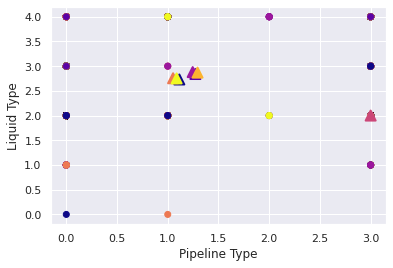

In [63]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_train)
y_pred = kmeans.predict(X_train)

df_clustering_results.loc[len(df_clustering_results), :] = ['K-Means', 
                                                            7, 
                                                            metrics.silhouette_score(X_train, y_pred), 
                                                            metrics.v_measure_score(y_train, y_pred)
                                                          ]

# plot the cluster assignments and cluster centers
plt.scatter(X_train[:, 2], X_train[:, 3], c=y_pred, cmap="plasma")
plt.scatter(kmeans.cluster_centers_[:, 2],   
            kmeans.cluster_centers_[:, 3],
            marker='^', 
            c=[0, 1, 2, 3, 4, 5, 6], 
            s=100, 
            linewidth=2,
            cmap="plasma")
plt.xlabel("Pipeline Type")
plt.ylabel("Liquid Type")

## DBSCAN (TODO: we may give up of this approach)

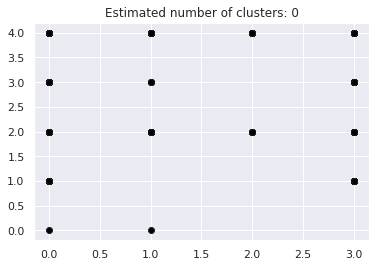

In [64]:
db = DBSCAN(eps=5, min_samples=50).fit(X_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_

n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

# saving for later comparision
# df_clustering_results.loc[len(df_clustering_results), :] = ['DBSCAN', 
#                                                             n_clusters_, 
#                                                             metrics.silhouette_score(X_train, db_labels), 
#                                                             metrics.v_measure_score(labels_true, db_labels)
#                                                           ]

# Black removed and is used for noise instead.
unique_labels = set(db_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (db_labels == k)

    xy = X_train[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 2], xy[:, 3], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 2], xy[:, 3], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [65]:
X_train[0]

array([2.0110000e+03, 1.3177683e+09, 0.0000000e+00, 2.0000000e+00,
       1.4230000e+03, 0.0000000e+00, 0.0000000e+00, 2.9890000e+03,
       7.8450000e+03, 0.0000000e+00, 1.2257000e+04, 1.0000000e+00,
       2.2000000e+01, 1.0000000e+01, 1.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00])

## Hierarquical Grouping

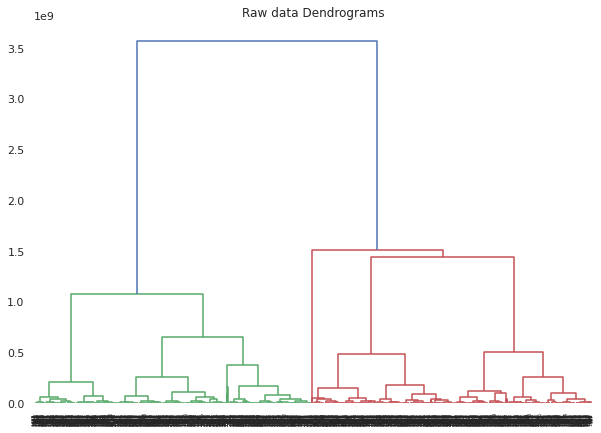

In [81]:
plt.figure(figsize=(10, 7))
plt.title("Raw data Dendrograms")
dend = shc.dendrogram(shc.linkage(X_train, method='ward'))

In [0]:
hc_cluster = AgglomerativeClustering(n_clusters=7, affinity='l2', linkage='complete')
hc_cluster.fit_predict(X_train)

hc_labels = hc_cluster.labels_

df_clustering_results.loc[len(df_clustering_results), :] = ['HC', 
                                                            n_clusters_, 
                                                            metrics.silhouette_score(X_train, hc_labels), 
                                                            metrics.v_measure_score(y_train, hc_labels)
                                                          ]

In [68]:
df_clustering_results

,alg,n_clusters,silhouette,V-measure
0,K-Means,7,0.559919,0.0115208
1,HC,0,0.557439,0.0100423


So, we can see that this dataset **has not** a **natural clustering**.

# Reducing dimensionality

## t-SNE

In [0]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X_train)

In [85]:
X_embedded

array([[ -1.2601383, -45.024143 ],
       [ 40.63279  ,  36.322254 ],
       [  6.675381 ,  40.56974  ],
       ...,
       [-30.532667 ,  49.048615 ],
       [-44.17288  ,  28.390831 ],
       [ -4.5503454,  -6.358177 ]], dtype=float32)

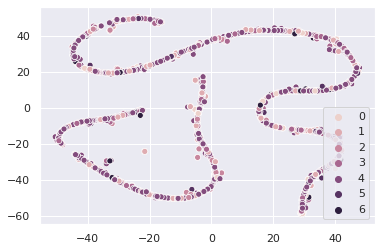

In [83]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_train, legend='full')

## PCA

In [0]:
scale = StandardScaler()
X_scaled = scale.fit_transform(X_train)

In [0]:
pca = PCA(n_components=2)
PCA_X = pca.fit_transform(X_scaled)

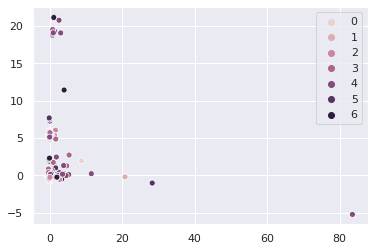

In [87]:
sns.scatterplot(PCA_X[:,0], PCA_X[:,1], hue=y_train, legend='full')

Based on the previous generated two approaches charts, we conclude that is not possible to use dimesionality reducing using t-SNE or PCA in this dataset, since **there is too much variance on it**.

# Using Supevised Machine Learning 

## Training models

In [0]:
estimators = {
              'Decision Tree': DecisionTreeClassifier(criterion = 'entropy', random_state = 0),
              'KNN': KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
              'Random Forest': RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0),
              'SVC': SVC(kernel = 'rbf', random_state = 0)
             }

In [0]:
df_results = pd.DataFrame(columns=['clf', 'acc', 'prec', 'rec', 'f1', 'score'], index=None)

In [76]:
for name, estim in estimators.items():

    estim.fit(X_train, y_train)

    y_pred = estim.predict(X_test)    
    
    # Storing the metrics for the current classifier
    df_results.loc[len(df_results), :] = [name, accuracy_score(y_test, y_pred), precision_score (y_test, y_pred, average = 'macro'),
                   recall_score(y_test, y_pred,  average = 'macro'), f1_score(y_test, y_pred,  average = 'macro'), estim.score(X_test, y_test)]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
df_results

,clf,acc,prec,rec,f1,score
0,Decision Tree,1,1,1,1,1
1,KNN,0.397482,0.129597,0.14156,0.135184,0.397482
2,Random Forest,0.971223,0.986905,0.86221,0.91047,0.971223
3,SVC,0.53777,0.0768243,0.142857,0.0999165,0.53777


Based on the previous results, the best model is
 the **Decision Tree**.

In [78]:
decision_tree_class = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
decision_tree_class.fit(X_train, y_train)
y_pred = decision_tree_class.predict(X_test)
y_pred

array([2, 4, 4, 1, 3, 0, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 1, 4, 3, 3, 4, 3,
       4, 3, 0, 1, 4, 1, 0, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 0, 4, 5, 4, 4,
       1, 0, 0, 3, 0, 3, 1, 1, 3, 4, 1, 4, 4, 1, 1, 4, 2, 4, 0, 4, 4, 0,
       0, 5, 4, 1, 4, 3, 3, 4, 4, 3, 3, 1, 1, 4, 4, 4, 4, 3, 1, 1, 4, 4,
       1, 1, 0, 4, 1, 4, 6, 1, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 3, 1, 3, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 3, 4, 1, 1, 6, 1, 4, 1, 4, 1, 3, 1,
       1, 4, 1, 1, 2, 4, 4, 4, 4, 0, 1, 4, 4, 1, 1, 1, 4, 4, 1, 1, 4, 3,
       1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 2, 3, 4, 1, 6, 4, 1, 4, 4, 4, 4,
       1, 4, 4, 4, 4, 3, 0, 4, 4, 4, 1, 4, 4, 1, 5, 0, 4, 5, 4, 1, 6, 4,
       4, 2, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 6, 1, 4, 4, 4, 3, 3, 2,
       4, 4, 4, 3, 0, 3, 4, 4, 5, 4, 4, 4, 0, 4, 1, 1, 1, 1, 3, 1, 4, 4,
       3, 4, 4, 5, 1, 4, 4, 4, 4, 4, 3, 4, 1, 1, 4, 4, 4, 4, 2, 2, 0, 4,
       1, 3, 4, 1, 4, 4, 4, 4, 4, 4, 4, 5, 3, 1, 4, 4, 1, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 1, 4, 5, 1, 4, 1, 0, 5, 1, 4, 4,

### Calculating the confusion matrix

In [79]:
mcm = multilabel_confusion_matrix(y_test, y_pred, labels=[*le_cause_cat_mapping])
mcm

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


array([[[556,   0],
        [  0,   0]],

       [[556,   0],
        [  0,   0]],

       [[556,   0],
        [  0,   0]],

       [[556,   0],
        [  0,   0]],

       [[556,   0],
        [  0,   0]],

       [[556,   0],
        [  0,   0]],

       [[556,   0],
        [  0,   0]]])

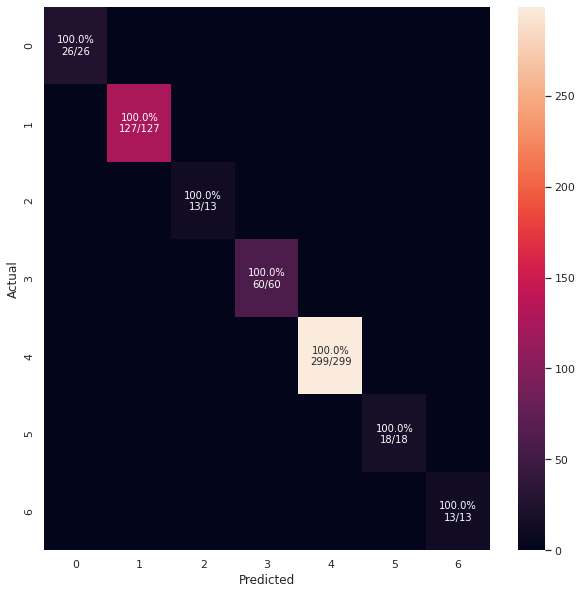

In [80]:
# code from https://stackoverflow.com/a/53235657

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, decision_tree_class.classes_, ymap=None, figsize=(10,10))

# Future works

* We can try to relate the accident city/state weather temperature/humidity with the cause category, as weel as the hour of day, day of week and month to discuss about it;
* Maybe we can relate the costs (where it is higher) to the pipeline location, pipeline type, liquid type, etc;